# Predicting "Opioid Prescribers" 

**The overarching aim of this project is to predict which Doctors will prescribe higher than average amounts of opiods and, thus, be termed an "Opiod Prescriber"


**The goals are to:**
- Wrangle the data
- Predict opiod prescribers in the USA
- Find which predictors are most significant
- Analyze and compare possible trends in opiod prescription within subfields in the USA and New Mexico, USA

**Dataset:**
The open source data for this project was acquired (and can be downloaded) from: https://www.kaggle.com/apryor6/us-opiate-prescriptions
The data is made up of three .csv files "opiods.csv", "overdoses.csv", and "prescriber-info.csv"

This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. This is a small subset of data that was sourced from cms.gov. The full dataset contains almost 24 million prescription instances in long format. Dr. Alan ("AJ") Pryor (who posted this dataset on Kaggle) has cleaned and compiled this data here in a format with 1 row per prescriber and limited the approximately 1 million total unique prescribers down to 25,000 to keep it manageable. For instructions on getting the full data, plese refer to the instructions listed by Dr. Pryor in the kaggle link above.

## **PART 1:**

## **Setup, Wrangling, and EDA 

### A. Import packages and get the data

In [1]:
#for data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import re

#for data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [2]:
prescriber = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/prescriber-info.csv')
opioids = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/opioids.csv')
overdose = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/overdoses.csv')

### B. First look at the PRESCRIBER DATASET first

#### 1. Prescriber Dataset

In [3]:
prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [4]:
prescriber.columns

Index(['NPI', 'Gender', 'State', 'Credentials', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=256)

In [5]:
prescriber.shape

(25000, 256)

We can see that that:
- There is a prescriber #, gender, state, credentials, and specialty followed by a list of drugs prescribed

**Let's see what the different specialties in the Specialty feature are...**

In [6]:
prescriber["Specialty"].value_counts().sort_values(ascending = False)

Internal Medicine                                                 3194
Family Practice                                                   2975
Dentist                                                           2800
Nurse Practitioner                                                2512
Physician Assistant                                               1839
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              615
Orthopedic Surgery                                                 575
Optometry                                                          571
Student in an Organized Health Care Education/Training Program     547
Ophthalmology                                                      519
General Surgery                                                    487
Gastro

**We can see that there are 109 different specialties listed (length)**

In [7]:
len(prescriber["Specialty"].value_counts().sort_values(ascending = False))

109

**Let's look at the credentials feature now...**

In [8]:
prescriber["Credentials"].value_counts().sort_values(ascending = False)

MD                     7034
M.D.                   6772
DDS                    1145
D.O.                    866
PA-C                    845
D.D.S.                  717
DO                      549
NP                      469
DMD                     449
PA                      437
O.D.                    353
FNP                     262
ARNP                    256
DPM                     247
M.D                     243
D.M.D.                  234
OD                      175
P.A.                    168
CRNP                    150
APRN                    134
N.P.                    105
D.P.M.                   98
PAC                      98
CNP                      86
D.D.S                    85
NP-C                     84
FNP-C                    70
APN                      66
FNP-BC                   56
P.A.-C                   52
                       ... 
MSPAS, PA-C               1
MD, RPVI                  1
APRN-FNP                  1
M.B.,B.S.                 1
MD, ABIHM           

##### From looking at the credentials, we see that:
- We have a mess as far as formating

- We will need to clean the credentials by:

    **-We will need to use Regex to make all of the same credentials have the same format (i.e. no periods or spaces)**
    - removing periods, commas, and dashes in all credentials
    - for all listings with multiple degrees in a single row, we will create new features called "Medical", "Doctorate", "Master", "Bachelor", "Associate", and "License" 
    - We will then look at the credential list again to make sure we have cleaned up all info.

**Let's start by removing periods and then replacing commas with a space**

In [9]:
prescriber = prescriber.replace({'Credentials': r'\.'}, {'Credentials': ''}, regex=True)
prescriber = prescriber.replace({'Credentials': r','}, {'Credentials': ' '}, regex=True)

In [10]:
prescriber["Credentials"].value_counts().sort_values(ascending = False)

MD                     14060
DDS                     1947
DO                      1462
PA-C                     923
DMD                      731
PA                       614
NP                       581
OD                       532
DPM                      354
FNP                      289
ARNP                     273
CRNP                     157
APRN                     139
PAC                      104
CNP                       92
MD  PHD                   87
NP-C                      85
FNP-C                     73
APN                       70
FNP-BC                    56
M D                       51
ANP                       47
MD  MPH                   43
RPA-C                     41
CFNP                      29
MD PHD                    28
MBBS                      26
MD                        25
PHARMD                    24
NURSE PRACTITIONER        23
                       ...  
DDS  BS                    1
ARNP  BSN  MN              1
NP  PHD                    1
MD  MMSC      

**Let's take care of a few special cases now before we split the column...**

**I'm formating the credentials so that I can split the column**

In [11]:
prescriber = prescriber.replace({'Credentials': r'M D'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D O'}, {'Credentials': 'DO'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'O D'}, {'Credentials': 'OD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D S'}, {'Credentials': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'P A'}, {'Credentials': 'PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD>'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D S M D'}, {'Credentials': 'DDS MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D O M S'}, {'Credentials': 'DDO MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'C FNP'}, {'Credentials': 'NP'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D P C'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D MPH'}, {'Credentials': 'MD MPH'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD ; MB BS'}, {'Credentials': 'MD MB MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'AT C CSCS'}, {'Credentials': 'ATC CSCS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MS;BS'}, {'Credentials': 'MS BS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D O P C'}, {'Credentials': 'DO'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'ACNP/FNP'}, {'Credentials': 'NP'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D F A A D'}, {'Credentials': 'MD FAAD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD/'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'PH D PA-C'}, {'Credentials': 'PA PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r' (DMD)'}, {'Credentials': 'DMD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'PH D MD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'DMD M S'}, {'Credentials': 'DMD MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D P M'}, {'Credentials': 'DPM'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD/PHD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'DD S'}, {'Credentials': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDPHD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDPA'}, {'Credentials': 'MD PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'R PA-C'}, {'Credentials': 'PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDFACP'}, {'Credentials': 'MD FACP'}, regex=True)

In [12]:
prescriber["Credentials"].value_counts().sort_values(ascending = False)

MD                     14113
DDS                     1953
DO                      1469
PA-C                     923
DMD                      731
PA                       616
NP                       582
OD                       536
DPM                      356
FNP                      289
ARNP                     273
CRNP                     157
APRN                     139
PAC                      104
CNP                       92
MD  PHD                   87
NP-C                      85
FNP-C                     73
APN                       70
FNP-BC                    56
ANP                       47
MD  MPH                   43
RPA-C                     41
MD PHD                    33
PHARMD                    31
CFNP                      29
MD                        28
MBBS                      26
NURSE PRACTITIONER        23
DDS  MS                   21
                       ...  
APRN-FNP                   1
RN MSN FNP-C               1
DDS  BS                    1
ARNP  BSN  MN 

**Now I'll split the column...**

In [13]:
# new data frame with split value columns 
new = prescriber["Credentials"].str.split(" ", n = 1, expand = True) 
  
# making seperate Cred1 (1st credential) column from new data frame 
prescriber["Cred1"]= new[0] 
  
# making seperate Cred2 column from new data frame 
prescriber["Cred2"]= new[1] 

In [14]:
pd.set_option('display.max_rows', 800)
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD                14480
DDS                2071
DO                 1492
PA-C                941
DMD                 777
PA                  639
NP                  592
OD                  547
DPM                 362
FNP                 303
ARNP                290
APRN                180
CRNP                161
PAC                 104
RN                  100
CNP                  95
NP-C                 86
APN                  81
FNP-C                74
FNP-BC               62
MSN                  61
ANP                  49
RPA-C                42
MBBS                 34
DNP                  33
PHARMD               32
MS                   31
CFNP                 29
NURSE                25
PHYSICIAN            23
CNM                  21
APNP                 21
ANP-BC               21
CNS                  15
APRN-BC              14
ND                   13
PHD                  13
RPAC                 13
PMHNP                12
ACNP-BC              12
ACNP                 12
ARNP-BC         

In [15]:
len(prescriber["Cred1"].value_counts().sort_values(ascending = False))

205

**We have 205 different credentials or formats for credentials**

Let's now combine degrees that are the same and also fill in nan values with "unknown"

In [16]:
# Nurse Practioner records:
for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.NP+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.NP.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP.'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.RN+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'RN+'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.PN+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PN+'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'NURSE'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.CNS+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.CNS.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS.'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'ANRP'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNFP'}, {'Cred1': 'NP'}, regex=True)
    
    
    
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [17]:
# uncomment to check it worked
# prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [18]:
# MD Records:

for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.MD+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.MD.+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD.+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD.'}, {'Cred1': 'MD'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'MBBS'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PHYSICIAN'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MBBCH'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MB'}, {'Cred1': 'MD'}, regex=True)
    
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [19]:
# uncomment to check it worked
# prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [20]:
# PA Records:

for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.PA+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.PA.+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA.+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA.'}, {'Cred1': 'PA'}, regex=True)
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [21]:
# uncomment to check it worked
#prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [22]:
# DDS (Dentist) Records:
prescriber = prescriber.replace({'Cred1': r'DMD'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DDS'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DDS.+'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DENTIST'}, {'Cred1': 'DDS'}, regex=True)


# OD (Optometrist) Records:
prescriber = prescriber.replace({'Cred1': r'OPHTHALMOLGIST'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OPTOMETRIST'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FAAO'}, {'Cred1': 'OD'}, regex=True)

# fill records where the physician name was incorrectly entered in the credentials with "unknown"
prescriber = prescriber.replace({'Cred1': r'ANNA'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GREG'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'HERSCHEL'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'EIN-'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BRIAN'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FLORA'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GERALD'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'JAMES'}, {'Cred1': 'Unknown'}, regex=True)

# Fix DPM error
prescriber = prescriber.replace({'Cred1': r'DPM`'}, {'Cred1': 'DPM'}, regex=True)


print ('Changes Complete')

Changes Complete


In [23]:
# uncomment to check it worked
#prescriber["Cred1"].value_counts().sort_values(ascending = False)

**Now let's look at the Cred1 and Cred2 columns together so we can fix places where the terminal degree wasn't in the Cred1 column.**

In [24]:
# Uncomment each ONE AT A TIME to inspect and find rows where we need to add Cred 1
#prescriber[prescriber.Cred2 == 'PA']
#prescriber[prescriber.Cred2 == 'MD']
#prescriber[prescriber.Cred2 == 'NP']
#prescriber[prescriber.Cred2 == 'DDS']
#prescriber[prescriber.Cred2 == 'OD']

**From the last step, I see that I need to change a few items**

In [25]:
prescriber = prescriber.replace({'Cred1': r'PHP'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FACEP'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^D$'}, {'Cred1': 'MD'}, regex=True)

prescriber = prescriber.replace({'Cred1': r'C-'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'ADULT'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DR'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSN'}, {'Cred1': 'NP'}, regex=True)

In [26]:
# uncomment to check it worked
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD         15375
NP          2469
DDS         2080
PA          1755
DO          1492
OD           550
DPM          363
MS            31
CNM           21
ND            13
PHD           13
Unknown        8
RPH            4
BDS            4
MHS            4
N              3
FAMILY         3
MEDICAL        3
DC             3
MMS            2
MED            2
PT             2
BS             2
PH             2
DDA            2
MFTI           1
ATC            1
BOARD          1
BSHS           1
MHSA           1
DNSC           1
PHC            1
PD             1
OTRL           1
MSSW           1
NFP            1
C              1
DOCTOR         1
BSN            1
BA             1
PCS            1
OO             1
MHSC           1
PSYD           1
MPT            1
M              1
GENERAL        1
MT             1
DP             1
RXN            1
AT             1
DPT            1
MSM            1
MNS            1
PMH            1
MN             1
Name: Cred1, dtype: int64

In [27]:
#I know used the below code (a few examples shown) to go through the results from the step above that had only a single record. 
#I did this to find out what was in the Cred2 column

#prescriber[prescriber.Cred1 == 'BA']
#prescriber[prescriber.Cred1 == 'PCS']
#prescriber[prescriber.Cred1 == 'MS']...

**By using the code in the cell above, I found several things to update in Cred1**

**I also looked at the results and decided to drop rows with credentials that had less than 32 records.**

In [28]:
#Making changes to Cred1 
prescriber = prescriber.replace({'Cred1': r'BA'}, {'Cred1': 'DO'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DNSC'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BSHS'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'ATC'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OO'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BSN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSSW'}, {'Cred1': 'LSW'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSM'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OTRL'}, {'Cred1': 'OT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DOCTOR'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^M$'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MPT'}, {'Cred1': 'PT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DPT'}, {'Cred1': 'PT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GENERAL'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'NFP'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MFTI'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BOARD'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PHC'}, {'Cred1': 'DDA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'AT'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PD'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PMH'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'RXN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^C$'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MHSA'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MMS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.drop(prescriber.index[6516])
prescriber = prescriber.replace({'Cred1': r'BS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber[prescriber.Cred1 != 'MED']
prescriber = prescriber[prescriber.Cred1 != 'DC']
prescriber = prescriber.replace({'Cred1': r'FAMILY'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^N$'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MEDICAL'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'RPH'}, {'Cred1': 'DDA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MHS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BDS'}, {'Cred1': 'DDS'}, regex=True)

print ('Changes Complete')

Changes Complete


In [29]:
# uncomment to check it worked
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD         15380
NP          2486
DDS         2085
PA          1764
DO          1493
OD           552
DPM          363
MS            31
CNM           21
PHD           13
ND            13
Unknown        9
DDA            7
PT             4
PH             2
DP             1
NPS            1
PSYD           1
OT             1
PCS            1
PAC            1
MT             1
LSW            1
Name: Cred1, dtype: int64

In [30]:

# dropping rows that had a credential that appeared less than 32 times.
prescriber = prescriber[prescriber.Cred1 != 'DP']
prescriber = prescriber[prescriber.Cred1 != 'MT']
prescriber = prescriber[prescriber.Cred1 != 'LSW']
prescriber = prescriber[prescriber.Cred1 != 'NPS']
prescriber = prescriber[prescriber.Cred1 != 'PSYD']
prescriber = prescriber[prescriber.Cred1 != 'PCS']
prescriber = prescriber[prescriber.Cred1 != 'OT']
prescriber = prescriber[prescriber.Cred1 != 'PH']
prescriber = prescriber[prescriber.Cred1 != 'PT']
prescriber = prescriber[prescriber.Cred1 != 'DDA']
prescriber = prescriber[prescriber.Cred1 != 'Unknown']
prescriber = prescriber[prescriber.Cred1 != 'MS']
prescriber = prescriber[prescriber.Cred1 != 'CNM']
prescriber = prescriber[prescriber.Cred1 != 'ND']
prescriber = prescriber[prescriber.Cred1 != 'PHD']
prescriber = prescriber[prescriber.Cred1 != 'PAC']
print ('Changes Complete')

Changes Complete


**We can now look at our Cred1 column and see that our data looks MUCH more clean than what we started with!**

In [31]:
# uncomment to check it worked
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD     15380
NP      2486
DDS     2085
PA      1764
DO      1493
OD       552
DPM      363
Name: Cred1, dtype: int64

**Now, we'll need to drop the "NPI" column since this is a different/individual id number for each prescriber.**

**We will also drop the "Cred2" feature and change the name of "Cred1" to "Degree"**

**We will also change the name of Gender to DR_Gender to clarify that this is the gender of the PRESCRIBER and not the patient**

In [32]:
prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Cred1,Cred2
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,1,DDS,None
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,35,1,MD,None
2,1427182161,F,NY,MD,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,25,0,MD,None
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,1,MD,None
4,1679650949,M,NV,MD,Hematology/Oncology,0,0,0,0,0,...,0,0,17,28,0,0,0,1,MD,None


In [33]:
prescriber = prescriber.drop('NPI', axis=1)
prescriber = prescriber.drop('Cred2', axis=1)
prescriber = prescriber.drop('Credentials', axis=1)
prescriber.rename(columns={'Cred1': 'Degree', 'Gender': 'DR_Gender'}, inplace=True)
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,DDS
1,F,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,35,1,MD
2,F,NY,General Practice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,25,0,MD
3,M,AZ,Internal Medicine,0,43,0,0,0,21,0,...,0,0,0,0,0,0,0,0,1,MD
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,...,0,0,0,17,28,0,0,0,1,MD


**Great!!**

**Now we've done a lot. We have all of the non-drug columns cleaned up pretty well.**

**Now, we need to address the drug columns.**

**Let's look at the drug columns now...**

In [34]:
prescriber.shape

(24886, 255)

In [35]:
pd.set_option('display.max_columns', 255)

In [36]:
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
#Uncomment if you'd like to see all the drug (column) names as a list

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(prescriber.head())

**All of the drug column names look good. We will normalize the values a little later for the alogorithms**

## **PART 2: EDA and Data Visualization**

### **Specialty Feature**

**Let's look at the 'Specialty' feature first...**

In [38]:
spec = prescriber["Specialty"].value_counts().sort_values(ascending = False)

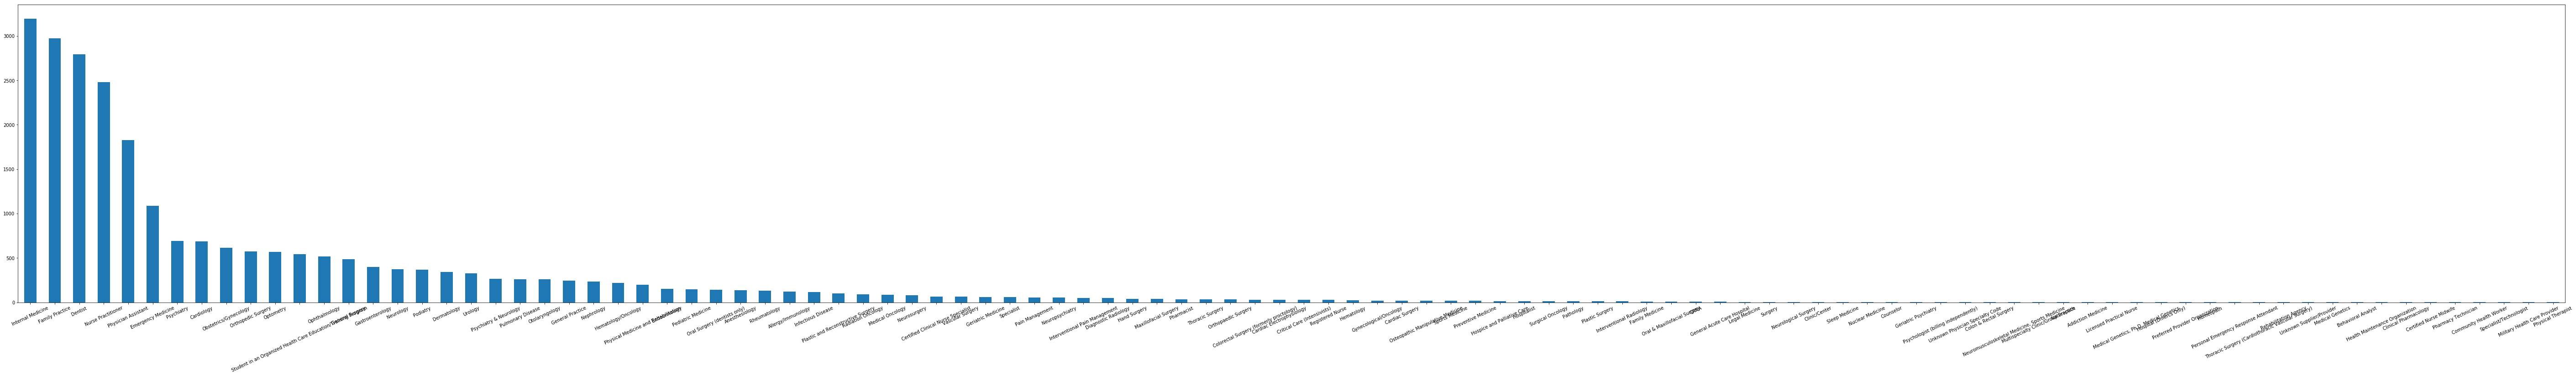

In [39]:
spec.plot(kind='bar', figsize = (100, 12))
plt.xticks(rotation=25)
plt.show()

**There are a lot of specialties, so let's look at the top 20**

In [40]:
spec[:20]

Internal Medicine                                                 3193
Family Practice                                                   2972
Dentist                                                           2795
Nurse Practitioner                                                2479
Physician Assistant                                               1826
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              614
Orthopedic Surgery                                                 575
Optometry                                                          570
Student in an Organized Health Care Education/Training Program     545
Ophthalmology                                                      518
General Surgery                                                    487
Gastro

### **Degree Feature**

**Let's look at the 'Degree' feature next...**

In [41]:
deg = prescriber["Degree"].value_counts().sort_values(ascending = False)

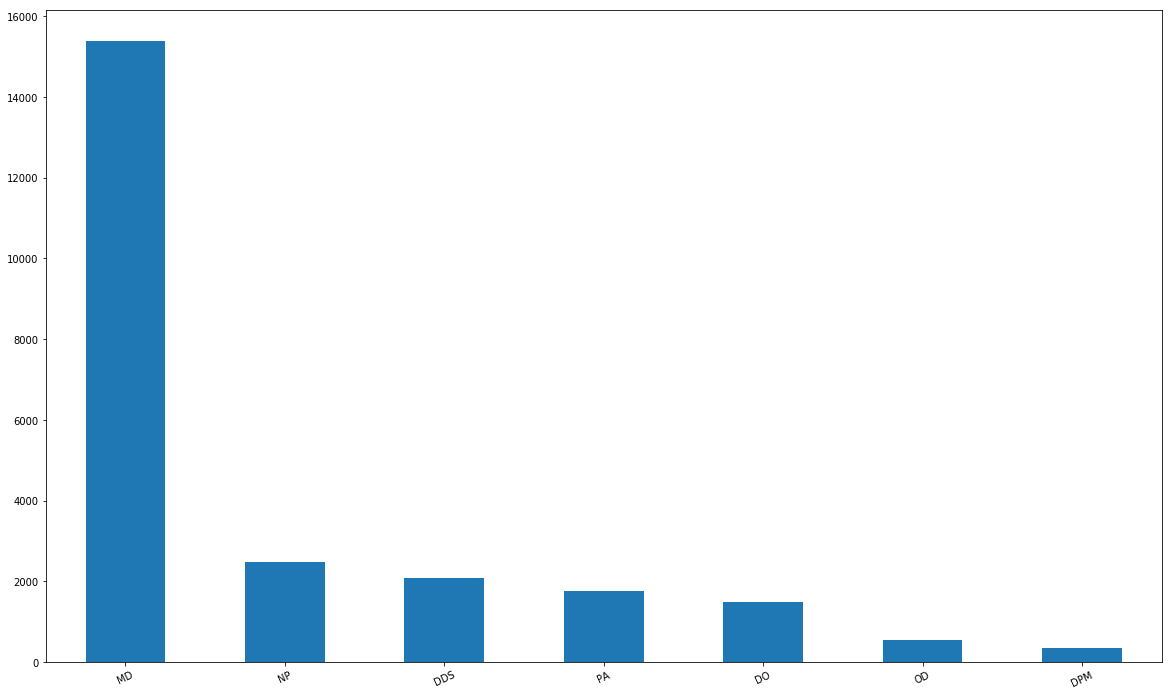

In [42]:
deg.plot(kind='bar', figsize = (20, 12))
plt.xticks(rotation=25)
plt.show()

### **DR_Gender Feature**

**Let's look at the 'DR_Gender' feature next...**

In [43]:
gen = prescriber["DR_Gender"].value_counts().sort_values(ascending = False)

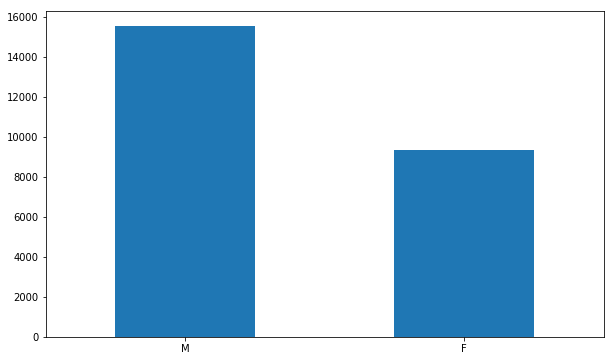

In [44]:
gen.plot(kind='bar', figsize = (10,6))
plt.xticks(rotation=0)
plt.show()

In [45]:
gen

M    15538
F     9348
Name: DR_Gender, dtype: int64

In [46]:
M=15538
F=9348
T = M + F
percentM = (M/T)*100
percentF = (F/T)*100
print ('There are', round(percentM, 1), '% male and', round(percentF, 1), '% female prescribers in the dataset')

There are 62.4 % male and 37.6 % female prescribers in the dataset


### **State Feature**

**Let's look at the 'State' feature next...**

In [47]:
sta = prescriber["State"].value_counts().sort_values(ascending = False)

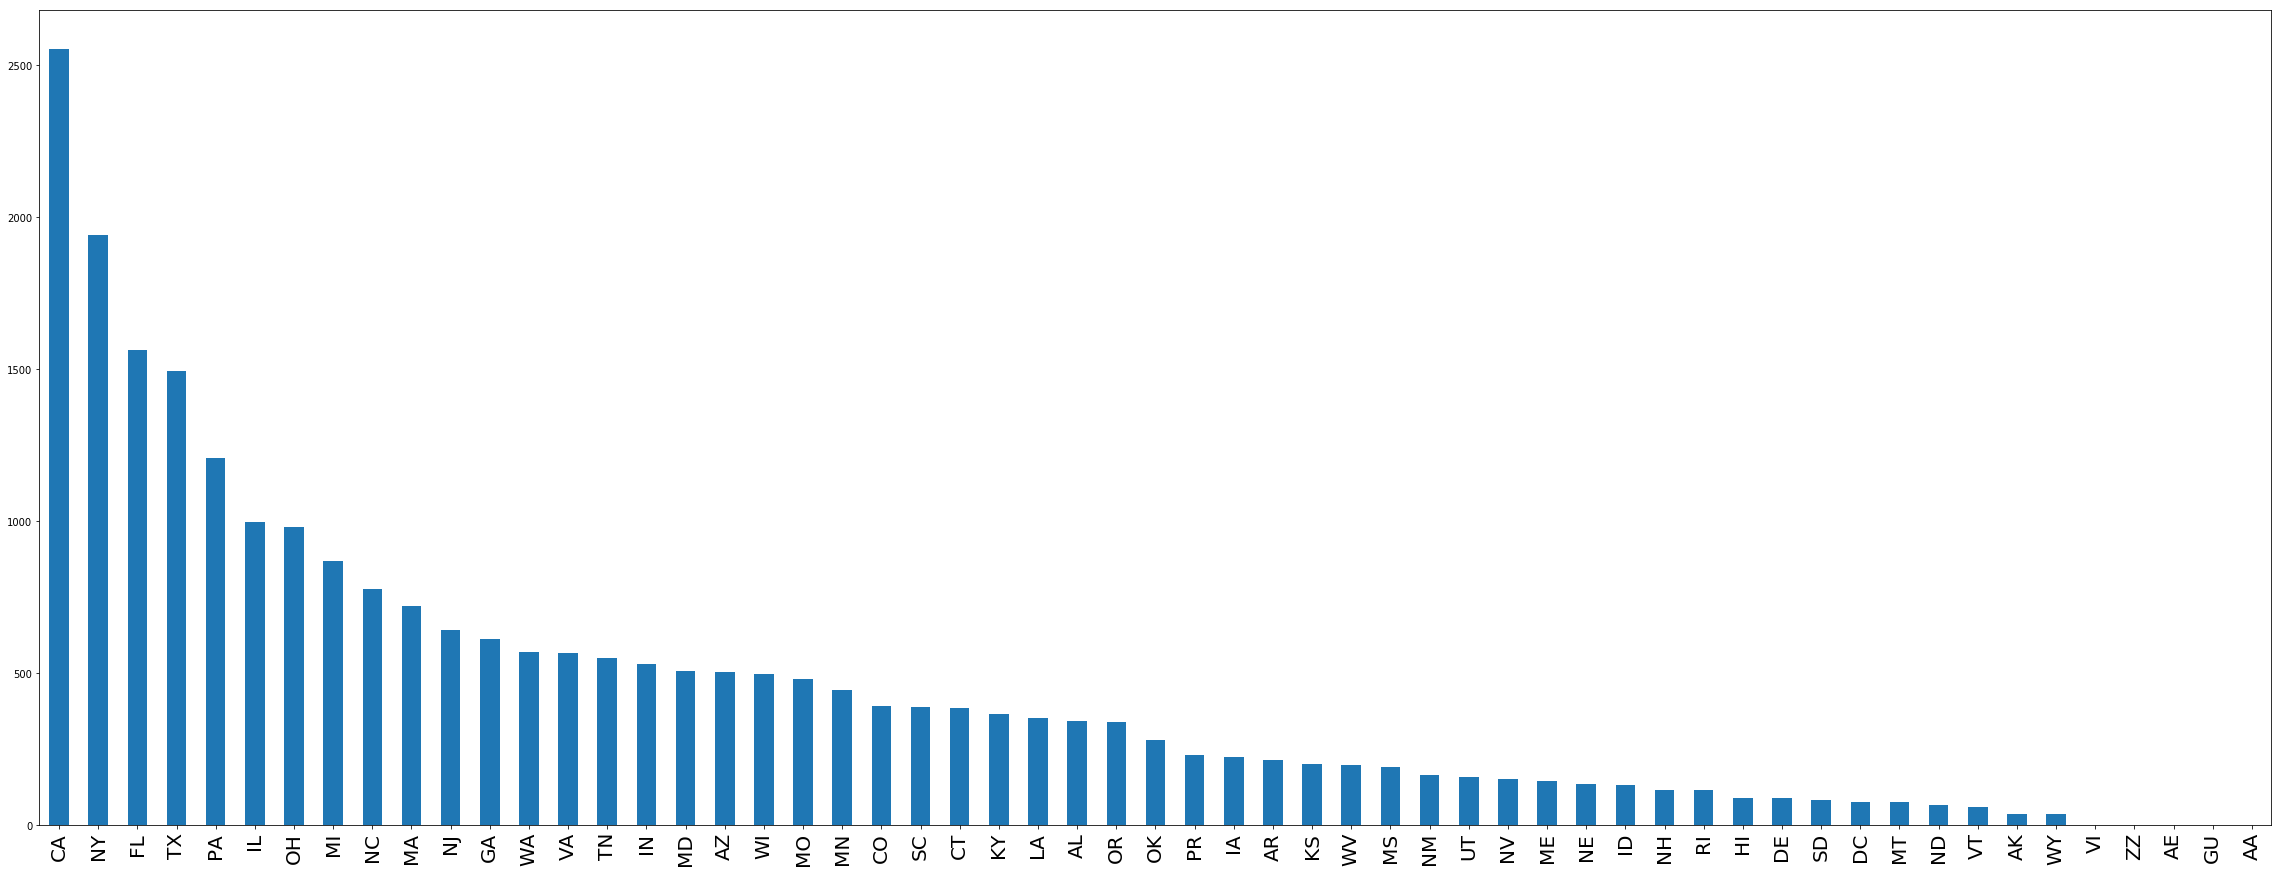

In [48]:
sta.plot(kind='bar', figsize = (40,15))
plt.xticks(fontsize=20)
plt.show()

In [49]:
len(sta)

57

In [50]:
#Uncomment to see full list of states
#sta

**We can see that there are a few errors in the states**

**We will drop rows from the prescriber dataframe that have incorrect state listings**

In [51]:
prescriber = prescriber[prescriber.State != 'VI']
prescriber = prescriber[prescriber.State != 'AE']
prescriber = prescriber[prescriber.State != 'ZZ']
prescriber = prescriber[prescriber.State != 'GU']
prescriber = prescriber[prescriber.State != 'AA']
print ('Changes Complete')

Changes Complete


**Now let's look again at the state data...**

In [52]:
sta = prescriber["State"].value_counts().sort_values(ascending = False)

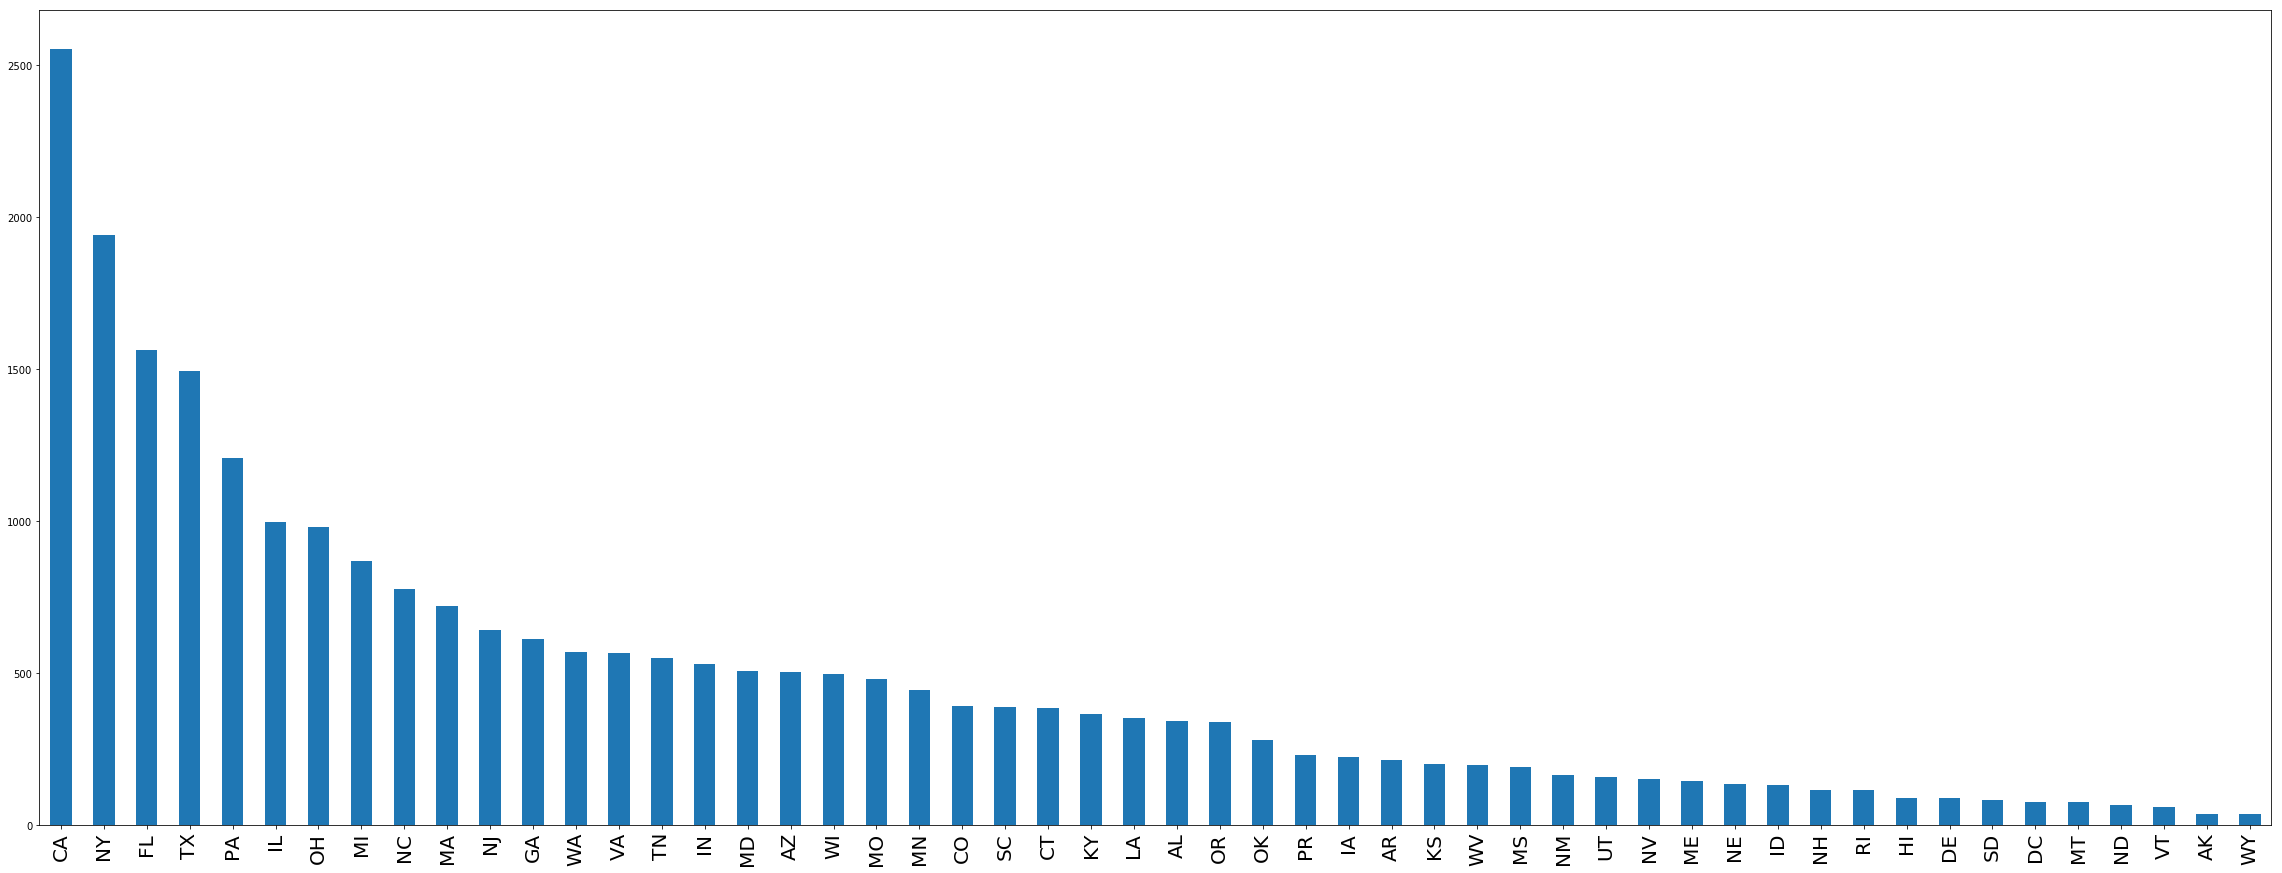

In [53]:
sta.plot(kind='bar', figsize = (40,15))
plt.xticks(fontsize=20)
plt.show()

In [54]:
#Uncomment to see full list of states
#sta
sta.shape[0]

52

**Great!**
**Now we've visualized and cleaned up the state feature and are left with data for 52 states, which is what we want.**

### **Target Variable: "Opioid.Prescriber"**

**Let's look at our target variable now, which is the Opioid.Prescriber feature...**

In [55]:
op = prescriber["Opioid.Prescriber"].value_counts().sort_values(ascending = False)

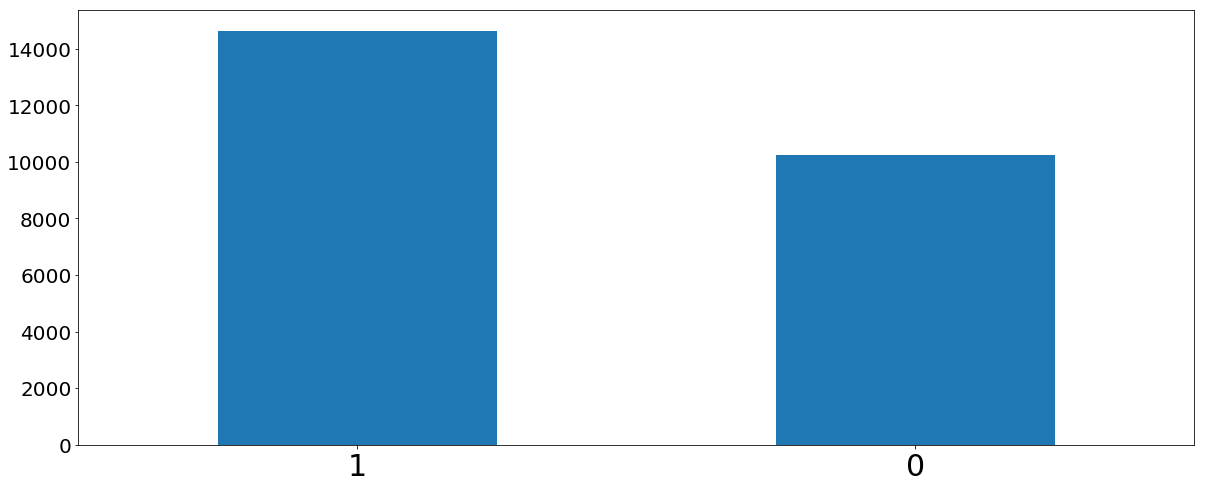

In [56]:
op.plot(kind='bar', figsize = (20,8))
plt.xticks(fontsize=30, rotation=0)
plt.yticks(fontsize=20)
plt.show()

In [57]:
op

1    14639
0    10237
Name: Opioid.Prescriber, dtype: int64

**We see that we have a fairly even split with 14,639 considered Opioid Prescribers and 10,237 that are not considered Opioid Prescribers**

## **PART 3: EDA With Correlations**

**Let's look for any correlations...**

In [58]:
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,

In [62]:
# Correlation between Specialty and Opioid.Prescriber
spec = prescriber[["Specialty", "Opioid.Prescriber"]].groupby(["Specialty"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
spec

,Specialty,Opioid.Prescriber
11,Clinical Pharmacology,1.000000
32,Health Maintenance Organization,1.000000
101,Unknown Supplier/Provider,1.000000
100,Unknown Physician Specialty Code,1.000000
81,Preferred Provider Organization,1.000000
97,Surgical Oncology,1.000000
14,Community Health Worker,1.000000
31,Hand Surgery,1.000000
66,Orthopedic Surgery,0.986087
69,Pain Management,0.963636


In [60]:
# Correlation between Degree and Opioid.Prescriber
degree_corr = prescriber[["Degree", "Opioid.Prescriber"]].groupby(["Degree"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
degree_corr

,Degree,Opioid.Prescriber
1,DO,0.772271
6,PA,0.687465
3,MD,0.619048
2,DPM,0.606061
4,NP,0.528158
0,DDS,0.390595
5,OD,0.007246


**The Degree correlations are interesting.**
**They could suggest that individuals with a DO or PA could need more training or oversight for opioid prescribing, to get the prescription levels down to equal that of MDs perhaps??**

In [61]:
# Correlation between DR_Gender and Opioid.Prescriber
gen_corr = prescriber[["DR_Gender", "Opioid.Prescriber"]].groupby(["DR_Gender"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
gen_corr

,DR_Gender,Opioid.Prescriber
1,M,0.613701
0,F,0.546554


## D. Split the data into test and training sets before we start data visualizations and analysis

Before we start using data visualization to look at the data closer, let's split it into a train and test set and then only look at the train set.

Our target is "Opioid.Prescriber" since we are trying to predict which prescribers might be considered opioid prescribers in the emergency medicne department.

In [ ]:
# Create target object and call it y
y=em_prescriber['Opioid.Prescriber']

# Create X
features = em_prescriber.columns.drop('Opioid.Prescriber')
X = em_prescriber[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state=1)

**Now let's see the information about the dataset...**

In [ ]:
prescriber.info()

#### 2. Opioid Dataset

In [ ]:
opioids.head()

In [ ]:
opioids.tail()

In [ ]:
opioids.info()

#### 3. Overdose Dataset

In [ ]:
overdose.head()

In [ ]:
overdose.tail()

In [ ]:
overdose.info()